In [5]:
import simpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Fontconfig warning: ignoring UTF-8: not a valid region tag
Matplotlib is building the font cache; this may take a moment.



To run the simulation, I started with ID/BP checkers =3 because if we need to check 5 passengers a minute and each check at this step takes about .75 minutes this is about 4 people every 3 minutes. Therefor 3 or less checkers would only check 4 passengers per minute.

That being said, with this starting parameter value of 3 ID/BP and Scanners, we see the highest average wait times and failure rates (all replication w/ an average wait time well above the 15 minute threshold) for scanners = 3 and 4.

Additionally, even when increasing the ID/BP checkers and having low number of scanners, the wait time did not decrease.

Notably, it looks like even when ID/Boarding Pass checker =5, if there are only Scanners = 3 the average wait time jumps back up to almost 1 hour and it appears that even though the passengers get through the initial queue ID/BP, there is a bottleneck when there are only 3 scanners.

This makes sense since there are 5 passengers arriving every minute (avg), if each scanner takes 0,5-1 min per passenger w/ an average of .75 minute, this is about 1.33 passengers a minute per scanner. If there are only 3 scanners, the through put is about 4 passengers per minute. However, if 5 passengers are arriving per minute, we are 1 passenger per minute short of the capacity we need for ID/BP = 5 and Scanners = 3 causing the increasing queue at this point.

In the simulation, **to achieve a 15 minute average wait time, the lowest average wait times begin at ID/Boarding Pass (BP) checkers = 4 and Scanners =4.**

To track performance, I also measured the standard deviation of the average wait time for multiple replications. In this, it suggest that the combination of ID/BP =4 & 5 Scanners = 4 & 5 were more consistenet and lower variability that the lower values.




BP: 3, SC: 3 → AvgWait: 64.89, StdWait: 6.60, Failures>15min: 100/100, AvgSystemTime: 66.39
BP: 3, SC: 4 → AvgWait: 60.82, StdWait: 7.92, Failures>15min: 100/100, AvgSystemTime: 62.32
BP: 3, SC: 5 → AvgWait: 59.80, StdWait: 8.60, Failures>15min: 100/100, AvgSystemTime: 61.30
BP: 4, SC: 3 → AvgWait: 59.17, StdWait: 5.59, Failures>15min: 100/100, AvgSystemTime: 60.66
BP: 4, SC: 4 → AvgWait: 3.46, StdWait: 1.27, Failures>15min: 0/100, AvgSystemTime: 4.96
BP: 4, SC: 5 → AvgWait: 2.38, StdWait: 1.29, Failures>15min: 0/100, AvgSystemTime: 3.87
BP: 5, SC: 3 → AvgWait: 59.11, StdWait: 6.00, Failures>15min: 100/100, AvgSystemTime: 60.61
BP: 5, SC: 4 → AvgWait: 1.49, StdWait: 0.43, Failures>15min: 0/100, AvgSystemTime: 2.98
BP: 5, SC: 5 → AvgWait: 0.42, StdWait: 0.07, Failures>15min: 0/100, AvgSystemTime: 1.92

=== Simulation Results ===
   BP Checkers  Scanners  Avg Wait  Std Wait  Replications Over 15 min Wait  \
0            3         3     64.89      6.60                            100   
1 

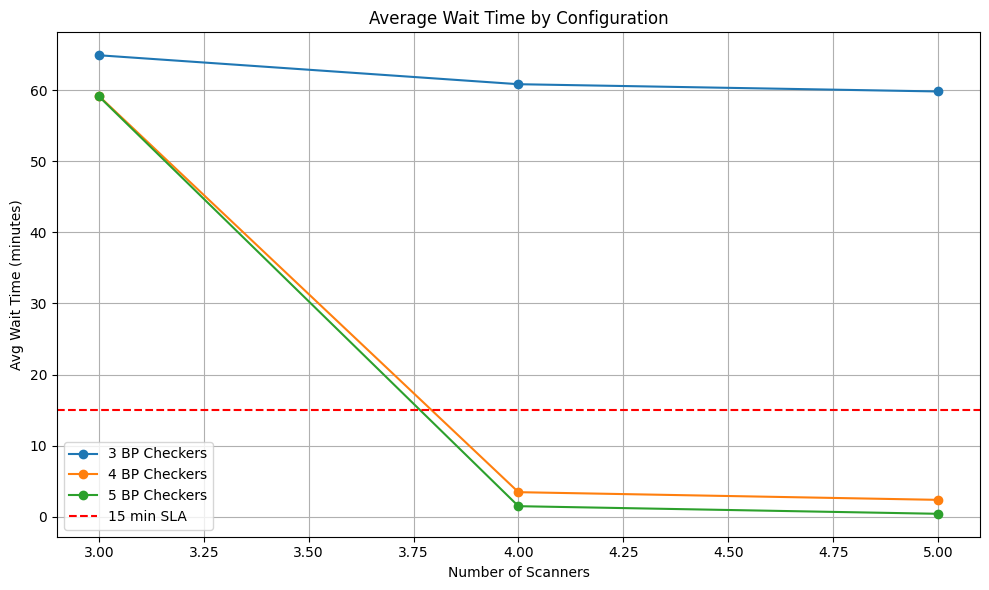

In [11]:

class AirportSim:
    def __init__(self, num_bpcheck, num_pcscanner, sim_time=600, arrival_rate=5.0):
        self.num_bpcheck = num_bpcheck
        self.num_pcscanner = num_pcscanner
        self.sim_time = sim_time
        self.arrival_rate = arrival_rate
        self.env = simpy.Environment()
        self.data = []

        self.bpchecks = simpy.Resource(self.env, capacity=self.num_bpcheck)
        self.pcscanners = simpy.Resource(self.env, capacity=self.num_pcscanner)

    def check_bp(self, passenger, check_time):
        """Simulate the time spent in boarding-pass check."""
        yield self.env.timeout(check_time)

    def check_ps(self, passenger, scan_time):
        """Simulate the time spent in personal scanner check."""
        yield self.env.timeout(scan_time)

    def passenger(self, name):
        """Process for a single passenger."""
        arrival_time = self.env.now

        # --- Stage 1: Boarding-pass check ---
        with self.bpchecks.request() as req1:
            yield req1
            check_time = np.random.exponential(scale=0.75)
            yield self.env.process(self.check_bp(name, check_time))
            bp_wait = round(self.env.now - arrival_time - check_time, 5)
            bp_out = self.env.now

        # --- Stage 2: Personal check ---
        with self.pcscanners.request() as req2:
            yield req2
            scan_time = np.random.uniform(0.5, 1.0)
            yield self.env.process(self.check_ps(name, scan_time))
            ps_wait = round(self.env.now - bp_out - scan_time, 5)

        total_wait = round(bp_wait + ps_wait, 5)
        # System time = total time from arrival to departure
        departure_time = self.env.now
        system_time = round(departure_time - arrival_time, 5)

        # Record relevant data for this passenger
        self.data.append((name, arrival_time, bp_wait, ps_wait, total_wait, system_time))

    def arrival_process(self):
        """Generate passengers according to a Poisson arrival process."""
        i = 0
        while True:
            yield self.env.timeout(np.random.exponential(scale=1/self.arrival_rate))
            i += 1
            self.env.process(self.passenger(f"P{i}"))

    def run(self):
        """Run the simulation and return a DataFrame of passenger results."""
        self.env.process(self.arrival_process())
        self.env.run(until=self.sim_time)
        df = pd.DataFrame(
            self.data, 
            columns=['Name', 'ArrivalTime', 'BPWait', 'PSWait', 'TotalWait', 'SystemTime']
        )
        return df

def run_experiments(bp_list, scanner_list, trials=10, sim_time=600):
    """
    For each combination of boarding-pass checkers and scanners:
      - Run the simulation 'trials' times
      - Compute average wait time and average system time across trials
    """
    all_results = []
    for bp in bp_list:
        for sc in scanner_list:
            wait_averages = []
            system_averages = []
            for _ in range(trials):
                sim = AirportSim(num_bpcheck=bp, num_pcscanner=sc, sim_time=sim_time)
                df = sim.run()
                wait_averages.append(df['TotalWait'].mean())
                system_averages.append(df['SystemTime'].mean())

            mean_wait = np.mean(wait_averages)
            std_wait = np.std(wait_averages)
            fail_count_wait = sum(1 for w in wait_averages if w > 15)

            mean_system = np.mean(system_averages)
            std_system = np.std(system_averages)

            # Add row: BP checkers, Scanners, Wait time stats, System time stats
            all_results.append([
                bp, 
                sc, 
                round(mean_wait, 2), 
                round(std_wait, 2), 
                fail_count_wait,
                round(mean_system, 2),
                round(std_system, 2)
            ])

            print(f"BP: {bp}, SC: {sc} → "
                  f"AvgWait: {mean_wait:.2f}, StdWait: {std_wait:.2f}, "
                  f"Failures>15min: {fail_count_wait}/{trials}, "
                  f"AvgSystemTime: {mean_system:.2f}")

    # Build a DataFrame for final results
    df_out = pd.DataFrame(
        all_results, 
        columns=[
            'BP Checkers', 
            'Scanners', 
            'Avg Wait', 
            'Std Wait', 
            'Replications Over 15 min Wait',
            'Avg System Time',
            'Std System Time'
        ]
    )
    print("\n=== Simulation Results ===")
    print(df_out)
    return df_out

def plot_experiment_results(results_df):
    """
    Plot average wait time by # scanners for each # of boarding-pass checkers.
    """
    fig, ax = plt.subplots(figsize=(10, 6))
    for bp in results_df['BP Checkers'].unique():
        sub = results_df[results_df['BP Checkers'] == bp]
        ax.plot(sub['Scanners'], sub['Avg Wait'], marker='o', label=f'{bp} BP Checkers')
    ax.axhline(y=15, color='red', linestyle='--', label='15 min SLA')
    ax.set_title('Average Wait Time by Configuration')
    ax.set_xlabel('Number of Scanners')
    ax.set_ylabel('Avg Wait Time (minutes)')
    ax.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    bp_checkers_range = [3, 4, 5]
    scanners_range = [3, 4, 5]

    results_df = run_experiments(bp_checkers_range, scanners_range, trials=100, sim_time=600)
    plot_experiment_results(results_df)
